<a href="https://colab.research.google.com/github/camulro/Aprendizaje-II/blob/sesi%C3%B3n4/VAE_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Extendido de:
# https://medium.com/dataseries/variational-autoencoder-with-pytorch-2d359cbf027b

Un autoencoder toma una entrada y la comprime al espacio latente. Comprime la imagen.
Garantiza continuidad


# **Variational AutoEncoder (VAE)**

<img src="https://drive.google.com/uc?export=download&id=15IMT9YVX61NA7836w4J3CIy_ec9fV0Y4" align="center" style="float" width="800">

### **Variational autoencoder**

El autoencoder estándar puede tener un problema debido a que el espacio latente puede ser irregular [1]. Es decir, puntos cercanos en el espacio latente pueden producir salidas muy diferentes, y sin sentido, en el decoder.

Una solución a esto es el Variational Autoencoder. Al igual que el autoencoder se compone de dos redes neuronales, el encoder y el decoder, pero hay varias diferencias. Por ejemplo, si el dataset son imágenes:

- El encoder toma como entrada una imagen y da como salida un **conjunto de puntos** en el espacio latente. Este conjunto de puntos es diferente para cada imagen, y se modeliza con una función de distribución Gaussiana donde la media y matriz de covarianza dependen de la imagen de entrada al encoder.

- El decoder toma como entrada **un punto** del espacio latente y da como salida una imagen. Para escoger un solo punto del conjunto devuelto por el encoder y modelizado por una Gaussiana, se hace un muestreo aleatorio de esa distribución de probabilidad.

En otras palabras, si el dataset son imágenes:

- El encoder toma como entrada una imagen y devuelve un vector media **E** y una matriz de covarianza **V** asociada a ese patrón. La media y covarianza son diferentes para cada imagen.

- Se hace un muestreo aleatorio de un solo punto de esa distribución de probabilidad. Este punto del espacio latente es la entrada al decoder.

- El error de reconstrucción de la imagen viene dado por la diferencia entre la entrada al encoder y la salida del decoder.

<img src="https://drive.google.com/uc?export=download&id=1kwK_AcpiAkZDiAtbR14UvWrBE_5uQ24a" align="center" style="float" width="800">

### **VAE Loss Function**

El loss del VAE consta de dos términos:

- El **error de reconstrucción**, que se obtiene comparando la entrada al encoder con la salida del decoder.

- El **término de regularización KL**, también llamada "divergencia de Kullback-Leibler" entre la distribución devuelta por el encoder y la distribución normal (distribución Gaussiana) [3]. Este término actúa como un regularizador en el espacio latente, haciendo que las distribuciones devueltas por el encoder sean lo más parecidas posibles a una distribución normal (distribución Gaussiana).

$$
loss = error\_reconstrucción + KL(z, N(0,I))
$$

### **Links de interés**

[1] https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

[2] https://atcold.github.io/pytorch-Deep-Learning/en/week08/08-3/

[3] https://avandekleut.github.io/vae/

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import plotly.io as pio

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE
import plotly.express as px

In [ ]:
CUDA  = False

#dataset = "MNIST"
#dataset = "FashionMNIST"
dataset = "EMNIST"

In [ ]:
data_dir = 'dataset'
if dataset == "MNIST":
    train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
    test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)
elif dataset == "FashionMNIST":
    train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
    test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)
else:
    # EMNIST:
    # https://arxiv.org/pdf/1702.05373.pdf
    # https://pytorch.org/vision/master/generated/torchvision.datasets.EMNIST.html

    split = "balanced"
    aux = [10,11,12,36,37,38]
    
    train_dataset = torchvision.datasets.EMNIST(data_dir, split=split, train=True, download=True)
    inds = [ind for ind,x in enumerate(train_dataset.targets) if x in aux]
    train_dataset.data    = train_dataset.data[inds]
    train_dataset.data    = np.swapaxes(train_dataset.data, 2, 1)
    train_dataset.targets = train_dataset.targets[inds]
    for i,a in enumerate(aux):
        train_dataset.targets[train_dataset.targets == a] = i
    
    test_dataset  = torchvision.datasets.EMNIST(data_dir, split=split, train=False, download=True)
    inds = [ind for ind,x in enumerate(test_dataset.targets) if x in aux]
    test_dataset.data     = test_dataset.data[inds]
    test_dataset.data     = np.swapaxes(test_dataset.data, 2, 1)
    test_dataset.targets  = test_dataset.targets[inds]  
    for i,a in enumerate(aux):
        test_dataset.targets[test_dataset.targets == a] = i

In [ ]:
train_dataset.data.shape

torch.Size([14400, 28, 28])

In [ ]:
train_dataset.targets.shape

torch.Size([14400])

In [ ]:
np.unique(train_dataset.targets)

array([0, 1, 2, 3, 4, 5])

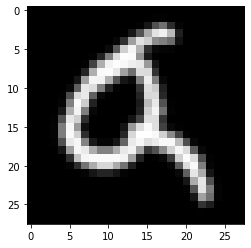

In [ ]:
i = 30
plt.imshow(train_dataset.data[i], cmap="gray");

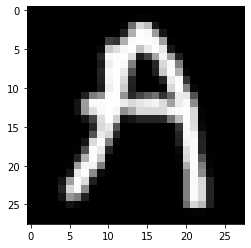

In [ ]:
plt.imshow(test_dataset.data[i], cmap="gray");

In [ ]:
test_dataset.data.shape

torch.Size([2400, 28, 28])

In [ ]:
test_dataset.targets.shape

torch.Size([2400])

In [ ]:
np.unique(test_dataset.targets)

array([0, 1, 2, 3, 4, 5])

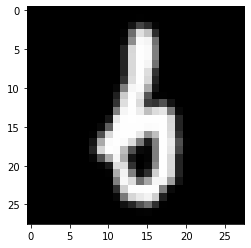

In [ ]:
plt.imshow(train_dataset.data[500], cmap="gray");

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [ ]:
m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [ ]:
i = 0
for x, _ in train_loader:
    print(x.shape)
    i += 1
    if i==10:
        break

torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])


## 1.Define Encoder and Decoder classes

**Formato de nn.conv2D:** nn.conv2D(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1)

- No incluye parámetro ReLU, eso se especifica dentro del forward, no aquí.
- En __init__ solo se especifican componentes dinámicos, entre ellos el Dropout (para que se pueda activar o desactivar en función de si se está en training o no)

**Visualización intuitiva de estos parámetros (incluyendo dilation):** https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

**La salida de Conv2d, si le llegan imágenes de tamaño INPUT_WIDTH x INPUT_WIDTH, tienen anchura (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html):**

$$\lfloor \frac{INPUT\_WIDTH + 2 \cdot PADDING - DILATION \cdot (KERNEL\_SIZE-1)}{STRIDE} \rfloor$$

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        
        # Formato de nn.conv2D:
        #    nn.conv2D(in_channels, out_channels, kernel_size, stride, padding)
        # No incluye parámetro ReLU, eso se especifica dentro del forward, no aquí.
        # En __init__ solo se especifican componentes dinámicos, entre ellos el Dropout
        # (para que se pueda activar o desactivar en función de si se está en training o no)

        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        # out_width = (INPUT_WIDTH + 2*PADDING - DILATION*(KERNEL_SIZE-1) - 1)/STRIDE + 1
        # Para imágenes de 28x28, padding=1, kernel_size=3 y stride = 2 (por defecto dilation=1):
        # out_width = (28 + 2*1 - 1*(3-1)) / 2 = 28 / 2 = 14
        
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        # out_width = (14 + 2*1 - 1*(3-1)) / 2 = 14 / 2 = 7

        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        # out_width = (7 + 2*0 - 1*(3-1)) / 2 = 3 (parte entera)
        # imágenes de 3x3, 32 canales. Número total de pixels: 3*3*32

        #self.drop1=nn.Dropout2d(p=0.3)

        # nn.Linear, como conv2D, no incluye parámetro ReLU, eso se especifica
        # dentro del forward.

        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        if CUDA:
            # media de la distribución normal (0):
            self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
            # desviación estándar de la distribución normal (1):
            self.N.scale = self.N.scale.cuda()
        self.kl = 0

    """
    def forward(self, x):
        #print(x.shape)
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    """
    
    def forward(self, x, debug=False):
        if debug:
            print("- Input shape:", x.shape)
        
        x = x.to(device)
        x = F.relu(self.conv1(x))
        if debug:
            print("- conv1 output shape:", x.shape)
        
        x = F.relu(self.batch2(self.conv2(x)))
        if debug:
            print("- conv2 output shape:", x.shape)
        
        x = F.relu(self.conv3(x))
        if debug:
            print("- conv3 output shape:", x.shape)
        
        x = torch.flatten(x, start_dim=1)
        if debug:
            print("- flatten output shape:", x.shape)
        
        x = F.relu(self.linear1(x))
        if debug:
            print("- linear1 output shape:", x.shape)

        mu =  self.linear2(x)
        if debug:
            print("- linear2 (mu) output shape:", mu.shape)

        sigma = torch.exp(self.linear3(x))
        if debug:
            print("- linear3 (sigma) output shape:", sigma.shape)

        z = mu + sigma*self.N.sample(mu.shape)
        if debug:
            print("- total output (z) shape:", z.shape)
        
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

## 2.Initialize model, optimizer, loss

In [ ]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 2

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cpu


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=2, bias=True)
    (linear3): Linear(in_features=128, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

In [ ]:
vae.encoder(train_dataset.data[:5].reshape(-1,1,28,28).type(torch.FloatTensor), debug=True)

- Input shape: torch.Size([5, 1, 28, 28])
- conv1 output shape: torch.Size([5, 8, 14, 14])
- conv2 output shape: torch.Size([5, 16, 7, 7])
- conv3 output shape: torch.Size([5, 32, 3, 3])
- flatten output shape: torch.Size([5, 288])
- linear1 output shape: torch.Size([5, 128])
- linear2 (mu) output shape: torch.Size([5, 2])
- linear3 (sigma) output shape: torch.Size([5, 2])
- total output (z) shape: torch.Size([5, 2])


tensor([[-0.2794, -0.5041],
        [ 0.4164, -2.0821],
        [-1.7221,  1.2543],
        [ 2.0278,  0.0648],
        [-0.3638, -0.1630]], grad_fn=<AddBackward0>)

## 3.Training

In [ ]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [ ]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [ ]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 61487.566406
	 partial train loss (single batch): 60486.363281
	 partial train loss (single batch): 59541.390625
	 partial train loss (single batch): 58806.503906
	 partial train loss (single batch): 58115.511719
	 partial train loss (single batch): 57494.371094
	 partial train loss (single batch): 56550.640625
	 partial train loss (single batch): 56273.105469
	 partial train loss (single batch): 55677.617188
	 partial train loss (single batch): 55385.410156
	 partial train loss (single batch): 54872.257812
	 partial train loss (single batch): 54370.507812
	 partial train loss (single batch): 53911.003906
	 partial train loss (single batch): 53447.246094
	 partial train loss (single batch): 53335.449219
	 partial train loss (single batch): 52816.250000
	 partial train loss (single batch): 52363.011719
	 partial train loss (single batch): 52363.128906
	 partial train loss (single batch): 52126.785156
	 partial train loss (single batch): 51626.460938


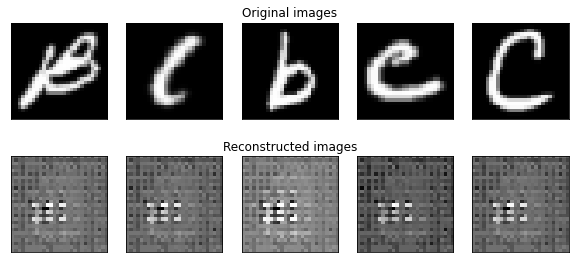

	 partial train loss (single batch): 45756.242188
	 partial train loss (single batch): 45736.355469
	 partial train loss (single batch): 45506.859375
	 partial train loss (single batch): 45450.507812
	 partial train loss (single batch): 45235.558594
	 partial train loss (single batch): 45126.292969
	 partial train loss (single batch): 44685.113281
	 partial train loss (single batch): 44633.761719
	 partial train loss (single batch): 44400.812500
	 partial train loss (single batch): 44334.671875
	 partial train loss (single batch): 43959.300781
	 partial train loss (single batch): 43752.312500
	 partial train loss (single batch): 43535.453125
	 partial train loss (single batch): 43225.769531
	 partial train loss (single batch): 43129.257812
	 partial train loss (single batch): 42858.042969
	 partial train loss (single batch): 42545.265625
	 partial train loss (single batch): 42617.320312
	 partial train loss (single batch): 42353.324219
	 partial train loss (single batch): 41963.539062


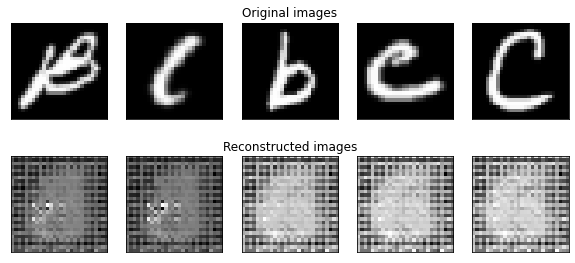

	 partial train loss (single batch): 35953.332031
	 partial train loss (single batch): 35820.011719
	 partial train loss (single batch): 35495.394531
	 partial train loss (single batch): 35492.472656
	 partial train loss (single batch): 35236.574219
	 partial train loss (single batch): 35093.316406
	 partial train loss (single batch): 34700.792969
	 partial train loss (single batch): 34598.523438
	 partial train loss (single batch): 34444.828125
	 partial train loss (single batch): 34315.039062
	 partial train loss (single batch): 33926.828125
	 partial train loss (single batch): 33780.667969
	 partial train loss (single batch): 33603.128906
	 partial train loss (single batch): 33365.292969
	 partial train loss (single batch): 33208.046875
	 partial train loss (single batch): 33050.359375
	 partial train loss (single batch): 32762.529297
	 partial train loss (single batch): 32865.933594
	 partial train loss (single batch): 32458.660156
	 partial train loss (single batch): 32221.357422


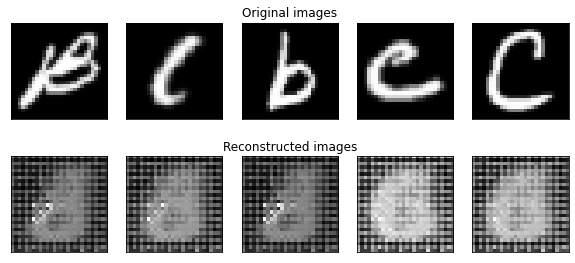

	 partial train loss (single batch): 27973.527344
	 partial train loss (single batch): 27862.820312
	 partial train loss (single batch): 27487.640625
	 partial train loss (single batch): 27595.722656
	 partial train loss (single batch): 27453.931641
	 partial train loss (single batch): 27386.376953
	 partial train loss (single batch): 27080.197266
	 partial train loss (single batch): 26988.800781
	 partial train loss (single batch): 26947.792969
	 partial train loss (single batch): 26864.515625
	 partial train loss (single batch): 26523.955078
	 partial train loss (single batch): 26449.720703
	 partial train loss (single batch): 26329.865234
	 partial train loss (single batch): 26249.109375
	 partial train loss (single batch): 26097.732422
	 partial train loss (single batch): 26115.630859
	 partial train loss (single batch): 25855.015625
	 partial train loss (single batch): 25990.281250
	 partial train loss (single batch): 25562.292969
	 partial train loss (single batch): 25465.777344


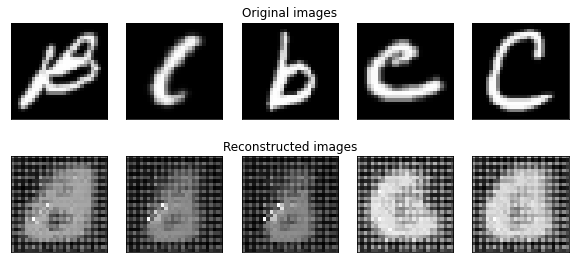

	 partial train loss (single batch): 22774.187500
	 partial train loss (single batch): 22752.810547
	 partial train loss (single batch): 22353.091797
	 partial train loss (single batch): 22491.021484
	 partial train loss (single batch): 22390.095703
	 partial train loss (single batch): 22444.031250
	 partial train loss (single batch): 22195.251953
	 partial train loss (single batch): 22106.980469
	 partial train loss (single batch): 22134.226562
	 partial train loss (single batch): 22108.363281
	 partial train loss (single batch): 21764.562500
	 partial train loss (single batch): 21865.750000
	 partial train loss (single batch): 21714.726562
	 partial train loss (single batch): 21738.582031
	 partial train loss (single batch): 21628.183594
	 partial train loss (single batch): 21789.970703
	 partial train loss (single batch): 21542.376953
	 partial train loss (single batch): 21617.664062
	 partial train loss (single batch): 21268.910156
	 partial train loss (single batch): 21223.062500


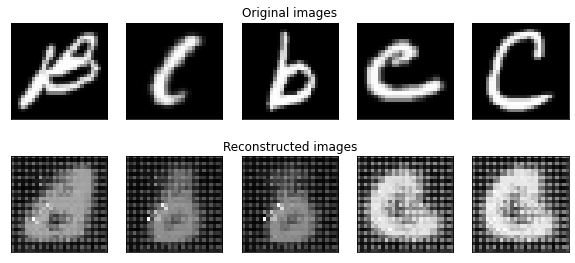

	 partial train loss (single batch): 19673.343750
	 partial train loss (single batch): 19664.433594
	 partial train loss (single batch): 19227.207031
	 partial train loss (single batch): 19373.652344
	 partial train loss (single batch): 19415.792969
	 partial train loss (single batch): 19375.031250
	 partial train loss (single batch): 19278.697266
	 partial train loss (single batch): 19184.957031
	 partial train loss (single batch): 19377.591797
	 partial train loss (single batch): 19249.566406
	 partial train loss (single batch): 18885.960938
	 partial train loss (single batch): 19018.777344
	 partial train loss (single batch): 18898.599609
	 partial train loss (single batch): 18914.353516
	 partial train loss (single batch): 18914.208984
	 partial train loss (single batch): 19153.937500
	 partial train loss (single batch): 18911.091797
	 partial train loss (single batch): 18941.199219
	 partial train loss (single batch): 18584.099609
	 partial train loss (single batch): 18666.261719


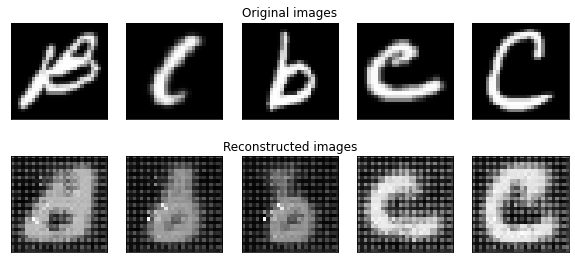

	 partial train loss (single batch): 17723.763672
	 partial train loss (single batch): 17710.826172
	 partial train loss (single batch): 17377.023438
	 partial train loss (single batch): 17433.888672
	 partial train loss (single batch): 17497.427734
	 partial train loss (single batch): 17478.833984
	 partial train loss (single batch): 17460.650391
	 partial train loss (single batch): 17279.232422
	 partial train loss (single batch): 17512.529297
	 partial train loss (single batch): 17395.062500
	 partial train loss (single batch): 16923.332031
	 partial train loss (single batch): 17237.574219
	 partial train loss (single batch): 17136.203125
	 partial train loss (single batch): 17254.748047
	 partial train loss (single batch): 17127.779297
	 partial train loss (single batch): 17437.398438
	 partial train loss (single batch): 17238.095703
	 partial train loss (single batch): 17225.804688
	 partial train loss (single batch): 16892.212891
	 partial train loss (single batch): 16958.765625


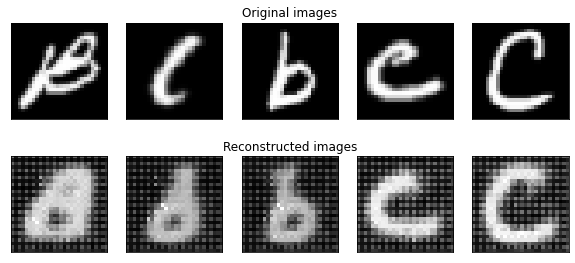

	 partial train loss (single batch): 16517.431641
	 partial train loss (single batch): 16442.199219
	 partial train loss (single batch): 16095.659180
	 partial train loss (single batch): 16102.871094
	 partial train loss (single batch): 16162.180664
	 partial train loss (single batch): 16224.751953
	 partial train loss (single batch): 16379.021484
	 partial train loss (single batch): 16024.949219
	 partial train loss (single batch): 16234.051758
	 partial train loss (single batch): 16214.949219
	 partial train loss (single batch): 15621.680664
	 partial train loss (single batch): 16136.501953
	 partial train loss (single batch): 16041.422852
	 partial train loss (single batch): 16139.096680
	 partial train loss (single batch): 15990.324219
	 partial train loss (single batch): 16296.839844
	 partial train loss (single batch): 15994.689453
	 partial train loss (single batch): 16072.976562
	 partial train loss (single batch): 15780.138672
	 partial train loss (single batch): 15870.462891


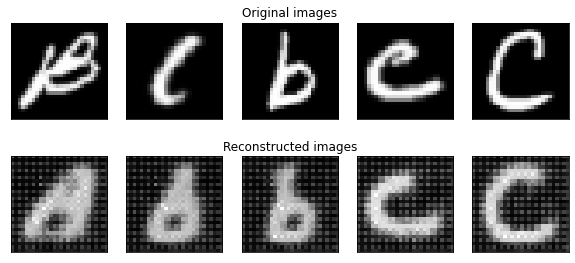

	 partial train loss (single batch): 15580.401367
	 partial train loss (single batch): 15547.054688
	 partial train loss (single batch): 15170.210938
	 partial train loss (single batch): 15142.361328
	 partial train loss (single batch): 15356.451172
	 partial train loss (single batch): 15285.891602
	 partial train loss (single batch): 15445.309570
	 partial train loss (single batch): 15055.197266
	 partial train loss (single batch): 15433.800781
	 partial train loss (single batch): 15342.892578
	 partial train loss (single batch): 14709.953125
	 partial train loss (single batch): 15250.524414
	 partial train loss (single batch): 15132.872070
	 partial train loss (single batch): 15181.864258
	 partial train loss (single batch): 15202.923828
	 partial train loss (single batch): 15485.004883
	 partial train loss (single batch): 15176.973633
	 partial train loss (single batch): 15284.669922
	 partial train loss (single batch): 14938.346680
	 partial train loss (single batch): 15048.449219


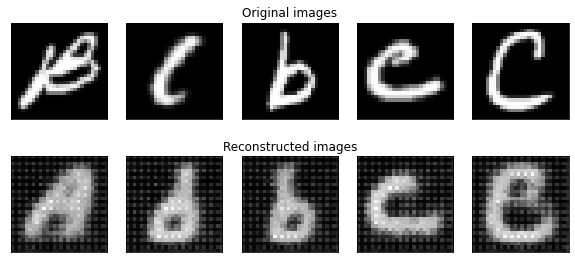

	 partial train loss (single batch): 14873.033203
	 partial train loss (single batch): 14843.651367
	 partial train loss (single batch): 14384.518555
	 partial train loss (single batch): 14423.477539
	 partial train loss (single batch): 14660.282227
	 partial train loss (single batch): 14612.268555
	 partial train loss (single batch): 14681.493164
	 partial train loss (single batch): 14388.634766
	 partial train loss (single batch): 14711.419922
	 partial train loss (single batch): 14741.863281
	 partial train loss (single batch): 13954.400391
	 partial train loss (single batch): 14582.755859
	 partial train loss (single batch): 14450.109375
	 partial train loss (single batch): 14572.046875
	 partial train loss (single batch): 14493.737305
	 partial train loss (single batch): 14835.182617
	 partial train loss (single batch): 14391.628906
	 partial train loss (single batch): 14651.611328
	 partial train loss (single batch): 14311.951172
	 partial train loss (single batch): 14254.145508


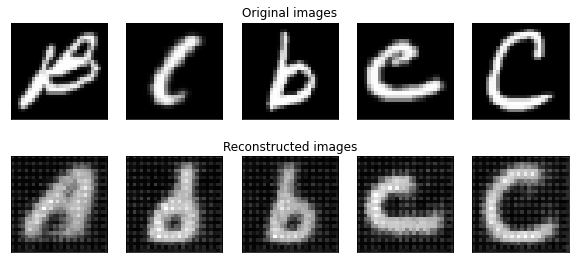

	 partial train loss (single batch): 14309.166016
	 partial train loss (single batch): 14306.466797
	 partial train loss (single batch): 13806.661133
	 partial train loss (single batch): 13830.803711
	 partial train loss (single batch): 14166.970703
	 partial train loss (single batch): 14119.059570
	 partial train loss (single batch): 14302.895508
	 partial train loss (single batch): 13789.346680
	 partial train loss (single batch): 14229.292969
	 partial train loss (single batch): 14263.228516
	 partial train loss (single batch): 13419.390625
	 partial train loss (single batch): 13992.226562
	 partial train loss (single batch): 13875.280273
	 partial train loss (single batch): 14056.166992
	 partial train loss (single batch): 13944.587891
	 partial train loss (single batch): 14315.343750
	 partial train loss (single batch): 13935.988281
	 partial train loss (single batch): 14157.132812
	 partial train loss (single batch): 13792.590820
	 partial train loss (single batch): 13733.283203


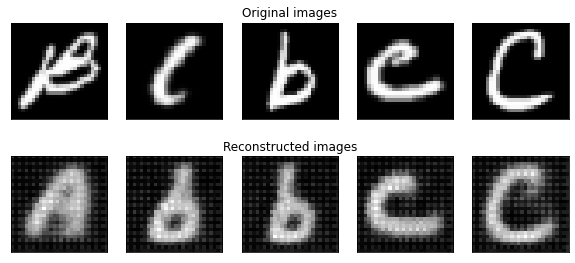

	 partial train loss (single batch): 13965.017578
	 partial train loss (single batch): 13870.278320
	 partial train loss (single batch): 13459.461914
	 partial train loss (single batch): 13469.720703
	 partial train loss (single batch): 13808.708984
	 partial train loss (single batch): 13596.331055
	 partial train loss (single batch): 13852.962891
	 partial train loss (single batch): 13442.125977
	 partial train loss (single batch): 13780.195312
	 partial train loss (single batch): 13858.244141
	 partial train loss (single batch): 13072.444336
	 partial train loss (single batch): 13623.683594
	 partial train loss (single batch): 13534.877930
	 partial train loss (single batch): 13722.185547
	 partial train loss (single batch): 13566.934570
	 partial train loss (single batch): 13899.947266
	 partial train loss (single batch): 13597.468750
	 partial train loss (single batch): 13790.865234
	 partial train loss (single batch): 13467.552734
	 partial train loss (single batch): 13471.538086


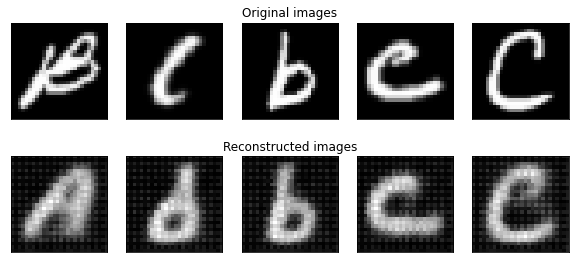

	 partial train loss (single batch): 13637.396484
	 partial train loss (single batch): 13542.837891
	 partial train loss (single batch): 13060.761719
	 partial train loss (single batch): 13139.291016
	 partial train loss (single batch): 13436.462891
	 partial train loss (single batch): 13262.298828
	 partial train loss (single batch): 13621.710938
	 partial train loss (single batch): 13115.845703
	 partial train loss (single batch): 13593.306641
	 partial train loss (single batch): 13501.617188
	 partial train loss (single batch): 12732.146484
	 partial train loss (single batch): 13382.341797
	 partial train loss (single batch): 13310.821289
	 partial train loss (single batch): 13408.644531
	 partial train loss (single batch): 13341.265625
	 partial train loss (single batch): 13610.285156
	 partial train loss (single batch): 13307.225586
	 partial train loss (single batch): 13526.875977
	 partial train loss (single batch): 13114.658203
	 partial train loss (single batch): 13178.701172


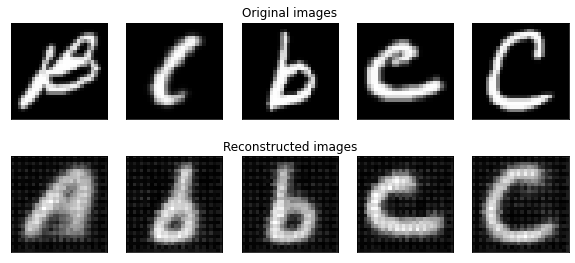

	 partial train loss (single batch): 13354.740234
	 partial train loss (single batch): 13321.525391
	 partial train loss (single batch): 12905.152344
	 partial train loss (single batch): 12882.876953
	 partial train loss (single batch): 13211.554688
	 partial train loss (single batch): 13066.957031
	 partial train loss (single batch): 13395.708984
	 partial train loss (single batch): 12869.962891
	 partial train loss (single batch): 13269.569336
	 partial train loss (single batch): 13320.496094
	 partial train loss (single batch): 12523.465820
	 partial train loss (single batch): 13004.625000
	 partial train loss (single batch): 13070.125977
	 partial train loss (single batch): 13127.833984
	 partial train loss (single batch): 13039.385742
	 partial train loss (single batch): 13377.929688
	 partial train loss (single batch): 12999.990234
	 partial train loss (single batch): 13259.258789
	 partial train loss (single batch): 12941.238281
	 partial train loss (single batch): 12951.492188


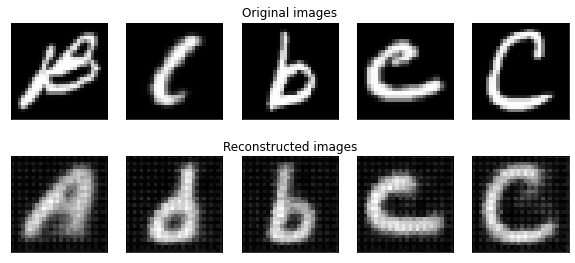

	 partial train loss (single batch): 13206.353516
	 partial train loss (single batch): 13153.557617
	 partial train loss (single batch): 12582.231445
	 partial train loss (single batch): 12630.200195
	 partial train loss (single batch): 13072.105469
	 partial train loss (single batch): 12835.027344
	 partial train loss (single batch): 13290.757812
	 partial train loss (single batch): 12628.519531
	 partial train loss (single batch): 13060.750000
	 partial train loss (single batch): 13125.676758
	 partial train loss (single batch): 12390.167969
	 partial train loss (single batch): 12869.125977
	 partial train loss (single batch): 12865.858398
	 partial train loss (single batch): 12918.329102
	 partial train loss (single batch): 12938.851562
	 partial train loss (single batch): 13121.875977
	 partial train loss (single batch): 12811.280273
	 partial train loss (single batch): 13072.339844
	 partial train loss (single batch): 12764.998047
	 partial train loss (single batch): 12686.365234


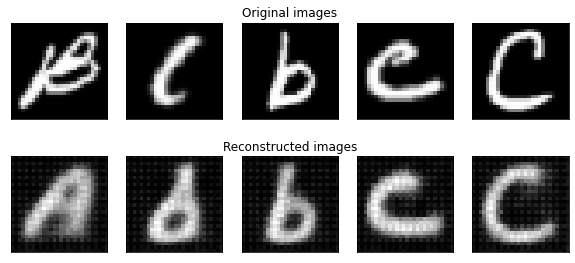

	 partial train loss (single batch): 13146.383789
	 partial train loss (single batch): 13044.908203
	 partial train loss (single batch): 12417.688477
	 partial train loss (single batch): 12455.453125
	 partial train loss (single batch): 12902.864258
	 partial train loss (single batch): 12732.945312
	 partial train loss (single batch): 13055.208008
	 partial train loss (single batch): 12509.958984
	 partial train loss (single batch): 12899.265625
	 partial train loss (single batch): 12912.250977
	 partial train loss (single batch): 12219.516602
	 partial train loss (single batch): 12792.744141
	 partial train loss (single batch): 12743.559570
	 partial train loss (single batch): 12798.783203
	 partial train loss (single batch): 12741.246094
	 partial train loss (single batch): 13092.176758
	 partial train loss (single batch): 12702.119141
	 partial train loss (single batch): 12870.570312
	 partial train loss (single batch): 12583.999023
	 partial train loss (single batch): 12623.555664


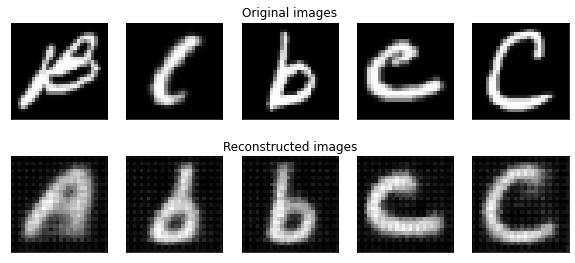

	 partial train loss (single batch): 12995.431641
	 partial train loss (single batch): 12822.451172
	 partial train loss (single batch): 12293.447266
	 partial train loss (single batch): 12247.930664
	 partial train loss (single batch): 12681.442383
	 partial train loss (single batch): 12614.619141
	 partial train loss (single batch): 12900.873047
	 partial train loss (single batch): 12374.995117
	 partial train loss (single batch): 12807.609375
	 partial train loss (single batch): 12861.549805
	 partial train loss (single batch): 12023.979492
	 partial train loss (single batch): 12540.828125
	 partial train loss (single batch): 12616.051758
	 partial train loss (single batch): 12638.545898
	 partial train loss (single batch): 12618.343750
	 partial train loss (single batch): 12895.820312
	 partial train loss (single batch): 12558.451172
	 partial train loss (single batch): 12804.421875
	 partial train loss (single batch): 12467.353516
	 partial train loss (single batch): 12452.127930


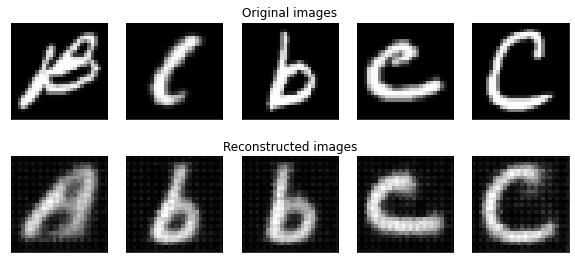

	 partial train loss (single batch): 12847.807617
	 partial train loss (single batch): 12719.280273
	 partial train loss (single batch): 12106.414062
	 partial train loss (single batch): 12321.278320
	 partial train loss (single batch): 12606.830078
	 partial train loss (single batch): 12528.037109
	 partial train loss (single batch): 12810.879883
	 partial train loss (single batch): 12384.644531
	 partial train loss (single batch): 12721.350586
	 partial train loss (single batch): 12675.876953
	 partial train loss (single batch): 12020.748047
	 partial train loss (single batch): 12515.978516
	 partial train loss (single batch): 12442.734375
	 partial train loss (single batch): 12563.126953
	 partial train loss (single batch): 12451.603516
	 partial train loss (single batch): 12841.102539
	 partial train loss (single batch): 12414.976562
	 partial train loss (single batch): 12728.306641
	 partial train loss (single batch): 12484.183594
	 partial train loss (single batch): 12336.144531


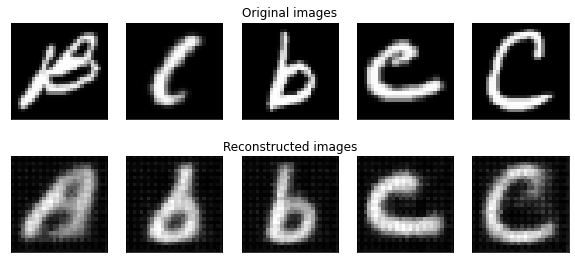

	 partial train loss (single batch): 12754.355469
	 partial train loss (single batch): 12640.431641
	 partial train loss (single batch): 12117.397461
	 partial train loss (single batch): 12187.392578
	 partial train loss (single batch): 12450.142578
	 partial train loss (single batch): 12361.212891
	 partial train loss (single batch): 12889.033203
	 partial train loss (single batch): 12226.889648
	 partial train loss (single batch): 12624.230469
	 partial train loss (single batch): 12597.105469
	 partial train loss (single batch): 11920.628906
	 partial train loss (single batch): 12422.370117
	 partial train loss (single batch): 12451.077148
	 partial train loss (single batch): 12569.128906
	 partial train loss (single batch): 12366.037109
	 partial train loss (single batch): 12839.031250
	 partial train loss (single batch): 12375.156250
	 partial train loss (single batch): 12585.557617
	 partial train loss (single batch): 12352.258789
	 partial train loss (single batch): 12261.717773


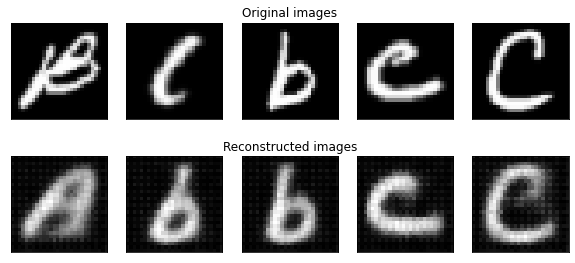

	 partial train loss (single batch): 12638.101562
	 partial train loss (single batch): 12579.719727
	 partial train loss (single batch): 11995.579102
	 partial train loss (single batch): 12080.447266
	 partial train loss (single batch): 12429.505859
	 partial train loss (single batch): 12285.416992
	 partial train loss (single batch): 12721.673828
	 partial train loss (single batch): 12118.793945
	 partial train loss (single batch): 12529.139648
	 partial train loss (single batch): 12561.242188
	 partial train loss (single batch): 11804.625000
	 partial train loss (single batch): 12372.914062
	 partial train loss (single batch): 12302.029297
	 partial train loss (single batch): 12442.100586
	 partial train loss (single batch): 12342.083008
	 partial train loss (single batch): 12693.929688
	 partial train loss (single batch): 12270.228516
	 partial train loss (single batch): 12542.386719
	 partial train loss (single batch): 12243.003906
	 partial train loss (single batch): 12233.053711


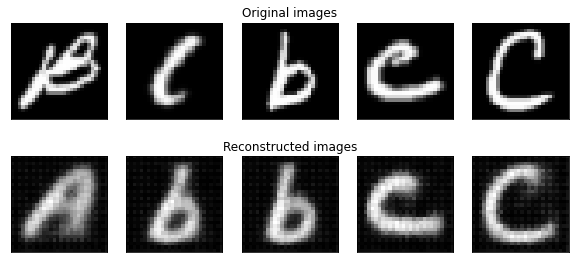

	 partial train loss (single batch): 12583.443359
	 partial train loss (single batch): 12460.498047
	 partial train loss (single batch): 11887.815430
	 partial train loss (single batch): 11947.469727
	 partial train loss (single batch): 12275.841797
	 partial train loss (single batch): 12258.426758
	 partial train loss (single batch): 12630.305664
	 partial train loss (single batch): 12095.283203
	 partial train loss (single batch): 12431.301758
	 partial train loss (single batch): 12460.096680
	 partial train loss (single batch): 11718.054688
	 partial train loss (single batch): 12274.902344
	 partial train loss (single batch): 12239.564453
	 partial train loss (single batch): 12314.533203
	 partial train loss (single batch): 12273.352539
	 partial train loss (single batch): 12683.852539
	 partial train loss (single batch): 12207.248047
	 partial train loss (single batch): 12462.879883
	 partial train loss (single batch): 12090.164062
	 partial train loss (single batch): 12214.148438


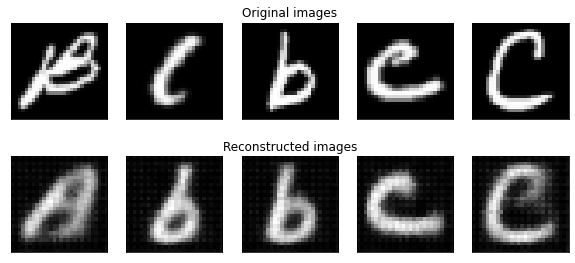

	 partial train loss (single batch): 12520.302734
	 partial train loss (single batch): 12430.151367
	 partial train loss (single batch): 11880.176758
	 partial train loss (single batch): 11964.659180
	 partial train loss (single batch): 12242.598633
	 partial train loss (single batch): 12156.416992
	 partial train loss (single batch): 12555.638672
	 partial train loss (single batch): 12049.955078
	 partial train loss (single batch): 12388.354492
	 partial train loss (single batch): 12367.385742
	 partial train loss (single batch): 11605.940430
	 partial train loss (single batch): 12230.271484
	 partial train loss (single batch): 12163.087891
	 partial train loss (single batch): 12282.375977
	 partial train loss (single batch): 12277.191406
	 partial train loss (single batch): 12628.861328
	 partial train loss (single batch): 12112.138672
	 partial train loss (single batch): 12299.226562
	 partial train loss (single batch): 12024.058594
	 partial train loss (single batch): 12105.666992


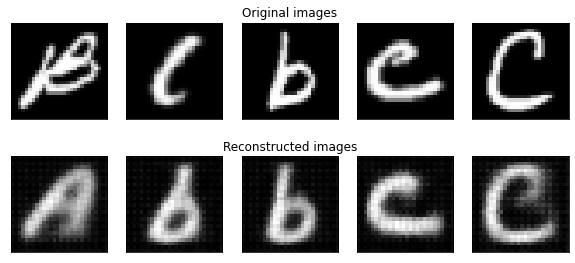

	 partial train loss (single batch): 12527.202148
	 partial train loss (single batch): 12389.634766
	 partial train loss (single batch): 11751.777344
	 partial train loss (single batch): 11916.427734
	 partial train loss (single batch): 12182.175781
	 partial train loss (single batch): 12041.234375
	 partial train loss (single batch): 12490.764648
	 partial train loss (single batch): 11967.871094
	 partial train loss (single batch): 12337.846680
	 partial train loss (single batch): 12282.151367
	 partial train loss (single batch): 11542.176758
	 partial train loss (single batch): 12170.227539
	 partial train loss (single batch): 12041.488281
	 partial train loss (single batch): 12257.976562
	 partial train loss (single batch): 12038.337891
	 partial train loss (single batch): 12513.573242
	 partial train loss (single batch): 12098.902344
	 partial train loss (single batch): 12286.085938
	 partial train loss (single batch): 11982.212891
	 partial train loss (single batch): 12073.937500


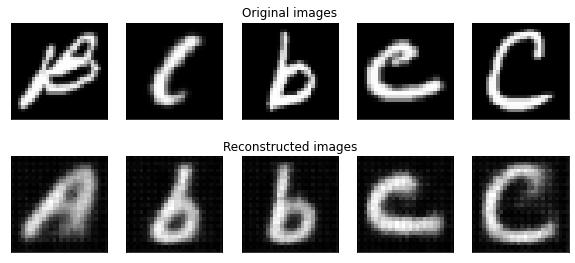

	 partial train loss (single batch): 12398.809570
	 partial train loss (single batch): 12313.804688
	 partial train loss (single batch): 11751.804688
	 partial train loss (single batch): 11790.053711
	 partial train loss (single batch): 12051.271484
	 partial train loss (single batch): 12062.296875
	 partial train loss (single batch): 12493.604492
	 partial train loss (single batch): 11916.973633
	 partial train loss (single batch): 12285.871094
	 partial train loss (single batch): 12250.212891
	 partial train loss (single batch): 11509.922852
	 partial train loss (single batch): 12103.833008
	 partial train loss (single batch): 12071.927734
	 partial train loss (single batch): 12169.404297
	 partial train loss (single batch): 12035.317383
	 partial train loss (single batch): 12493.999023
	 partial train loss (single batch): 12000.583984
	 partial train loss (single batch): 12308.834961
	 partial train loss (single batch): 11976.683594
	 partial train loss (single batch): 11967.843750


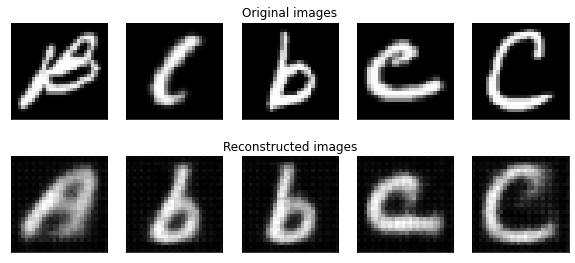

	 partial train loss (single batch): 12432.629883
	 partial train loss (single batch): 12257.742188
	 partial train loss (single batch): 11788.902344
	 partial train loss (single batch): 11706.679688
	 partial train loss (single batch): 12070.755859
	 partial train loss (single batch): 11979.630859
	 partial train loss (single batch): 12426.618164
	 partial train loss (single batch): 11877.287109
	 partial train loss (single batch): 12236.230469
	 partial train loss (single batch): 12104.935547
	 partial train loss (single batch): 11444.695312
	 partial train loss (single batch): 12070.459961
	 partial train loss (single batch): 11999.253906
	 partial train loss (single batch): 12078.033203
	 partial train loss (single batch): 12034.214844
	 partial train loss (single batch): 12390.555664
	 partial train loss (single batch): 11971.304688
	 partial train loss (single batch): 12253.718750
	 partial train loss (single batch): 11863.789062
	 partial train loss (single batch): 11939.266602


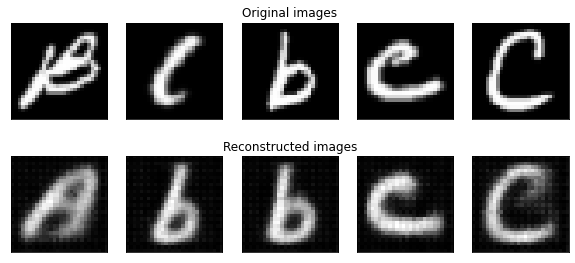

	 partial train loss (single batch): 12323.005859
	 partial train loss (single batch): 12306.294922
	 partial train loss (single batch): 11647.773438
	 partial train loss (single batch): 11685.426758
	 partial train loss (single batch): 12031.710938
	 partial train loss (single batch): 12026.133789
	 partial train loss (single batch): 12415.687500
	 partial train loss (single batch): 11805.060547
	 partial train loss (single batch): 12211.426758
	 partial train loss (single batch): 12206.577148
	 partial train loss (single batch): 11516.069336
	 partial train loss (single batch): 12013.108398
	 partial train loss (single batch): 12043.825195
	 partial train loss (single batch): 12143.662109
	 partial train loss (single batch): 12087.265625
	 partial train loss (single batch): 12456.140625
	 partial train loss (single batch): 12064.689453
	 partial train loss (single batch): 12194.767578
	 partial train loss (single batch): 11863.556641
	 partial train loss (single batch): 12000.258789


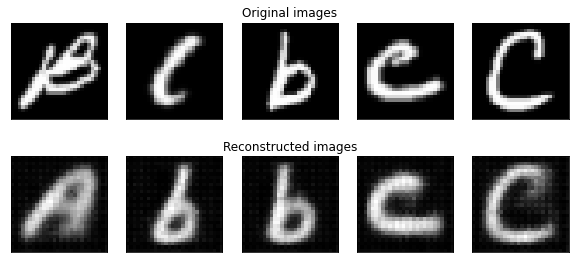

	 partial train loss (single batch): 12212.723633
	 partial train loss (single batch): 12240.750977
	 partial train loss (single batch): 11533.391602
	 partial train loss (single batch): 11641.124023
	 partial train loss (single batch): 12020.055664
	 partial train loss (single batch): 11969.497070
	 partial train loss (single batch): 12339.416992
	 partial train loss (single batch): 11791.413086
	 partial train loss (single batch): 12162.105469
	 partial train loss (single batch): 12143.661133
	 partial train loss (single batch): 11423.980469
	 partial train loss (single batch): 11996.077148
	 partial train loss (single batch): 11932.181641
	 partial train loss (single batch): 12032.640625
	 partial train loss (single batch): 11955.580078
	 partial train loss (single batch): 12360.944336
	 partial train loss (single batch): 11933.019531
	 partial train loss (single batch): 12135.104492
	 partial train loss (single batch): 11836.779297
	 partial train loss (single batch): 11899.167969


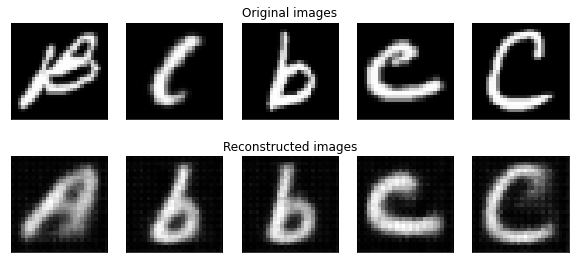

	 partial train loss (single batch): 12245.709961
	 partial train loss (single batch): 12307.506836
	 partial train loss (single batch): 11548.994141
	 partial train loss (single batch): 11568.223633
	 partial train loss (single batch): 12002.139648
	 partial train loss (single batch): 11895.224609
	 partial train loss (single batch): 12338.566406
	 partial train loss (single batch): 11758.349609
	 partial train loss (single batch): 12109.254883
	 partial train loss (single batch): 12054.198242
	 partial train loss (single batch): 11364.792969
	 partial train loss (single batch): 11984.939453
	 partial train loss (single batch): 11882.947266
	 partial train loss (single batch): 12026.945312
	 partial train loss (single batch): 11880.612305
	 partial train loss (single batch): 12313.232422
	 partial train loss (single batch): 11940.173828
	 partial train loss (single batch): 12163.341797
	 partial train loss (single batch): 11751.950195
	 partial train loss (single batch): 11973.365234


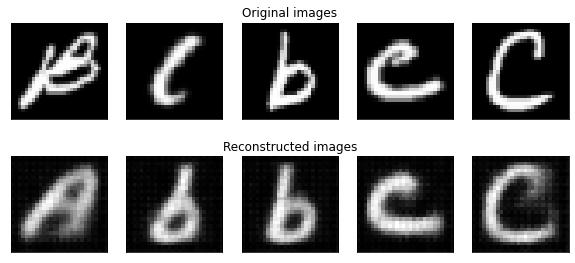

	 partial train loss (single batch): 12158.026367
	 partial train loss (single batch): 12151.595703
	 partial train loss (single batch): 11550.988281
	 partial train loss (single batch): 11588.105469
	 partial train loss (single batch): 11963.419922
	 partial train loss (single batch): 11920.696289
	 partial train loss (single batch): 12285.099609
	 partial train loss (single batch): 11681.060547
	 partial train loss (single batch): 12060.438477
	 partial train loss (single batch): 12062.959961
	 partial train loss (single batch): 11331.705078
	 partial train loss (single batch): 11916.973633
	 partial train loss (single batch): 11821.881836
	 partial train loss (single batch): 12006.942383
	 partial train loss (single batch): 11916.833984
	 partial train loss (single batch): 12235.174805
	 partial train loss (single batch): 11809.616211
	 partial train loss (single batch): 12085.390625
	 partial train loss (single batch): 11720.907227
	 partial train loss (single batch): 11808.016602


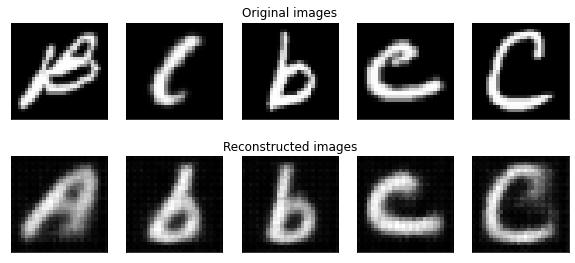

	 partial train loss (single batch): 12214.475586
	 partial train loss (single batch): 12138.582031
	 partial train loss (single batch): 11445.259766
	 partial train loss (single batch): 11520.159180
	 partial train loss (single batch): 11856.051758
	 partial train loss (single batch): 11874.540039
	 partial train loss (single batch): 12315.681641
	 partial train loss (single batch): 11648.776367
	 partial train loss (single batch): 12040.408203
	 partial train loss (single batch): 11986.594727
	 partial train loss (single batch): 11256.007812
	 partial train loss (single batch): 11932.043945
	 partial train loss (single batch): 11764.730469
	 partial train loss (single batch): 11935.892578
	 partial train loss (single batch): 11920.183594
	 partial train loss (single batch): 12250.954102
	 partial train loss (single batch): 11828.121094
	 partial train loss (single batch): 11999.815430
	 partial train loss (single batch): 11705.187500
	 partial train loss (single batch): 11746.599609


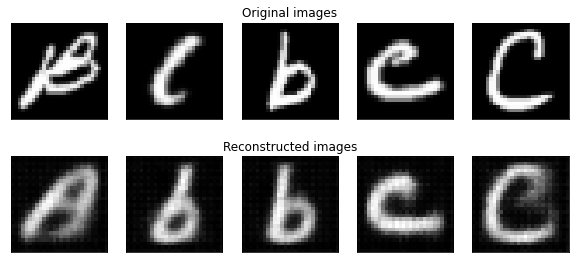

	 partial train loss (single batch): 12121.453125
	 partial train loss (single batch): 12108.109375
	 partial train loss (single batch): 11461.976562
	 partial train loss (single batch): 11515.057617
	 partial train loss (single batch): 11888.127930
	 partial train loss (single batch): 11846.231445
	 partial train loss (single batch): 12206.062500
	 partial train loss (single batch): 11607.439453
	 partial train loss (single batch): 12029.479492
	 partial train loss (single batch): 11944.027344
	 partial train loss (single batch): 11254.373047
	 partial train loss (single batch): 11861.833008
	 partial train loss (single batch): 11776.603516
	 partial train loss (single batch): 11876.577148
	 partial train loss (single batch): 11818.355469
	 partial train loss (single batch): 12211.904297
	 partial train loss (single batch): 11778.642578
	 partial train loss (single batch): 12087.459961
	 partial train loss (single batch): 11714.739258
	 partial train loss (single batch): 11759.814453


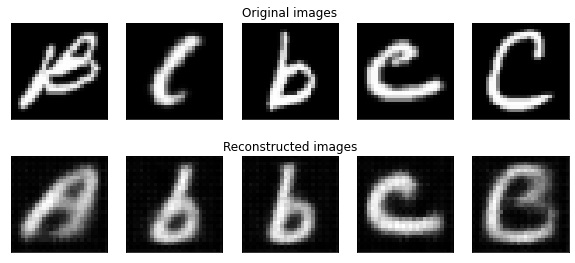

	 partial train loss (single batch): 12162.543945
	 partial train loss (single batch): 12108.121094
	 partial train loss (single batch): 11489.488281
	 partial train loss (single batch): 11478.433594
	 partial train loss (single batch): 11812.926758
	 partial train loss (single batch): 11856.706055
	 partial train loss (single batch): 12232.914062
	 partial train loss (single batch): 11602.187500
	 partial train loss (single batch): 11994.484375
	 partial train loss (single batch): 11941.572266
	 partial train loss (single batch): 11286.351562
	 partial train loss (single batch): 11917.462891
	 partial train loss (single batch): 11785.799805
	 partial train loss (single batch): 11862.810547
	 partial train loss (single batch): 11788.836914
	 partial train loss (single batch): 12254.734375
	 partial train loss (single batch): 11747.037109
	 partial train loss (single batch): 11986.314453
	 partial train loss (single batch): 11692.369141
	 partial train loss (single batch): 11762.868164


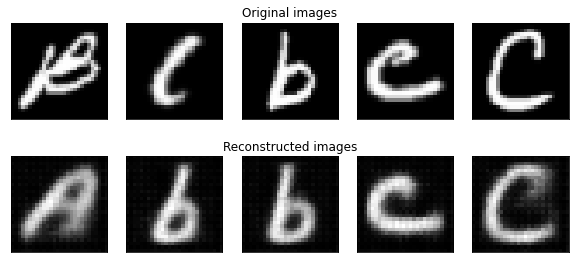

	 partial train loss (single batch): 12097.769531
	 partial train loss (single batch): 12067.802734
	 partial train loss (single batch): 11526.699219
	 partial train loss (single batch): 11484.676758
	 partial train loss (single batch): 11819.076172
	 partial train loss (single batch): 11849.298828
	 partial train loss (single batch): 12244.833984
	 partial train loss (single batch): 11616.019531
	 partial train loss (single batch): 11984.489258
	 partial train loss (single batch): 11957.020508
	 partial train loss (single batch): 11207.995117
	 partial train loss (single batch): 11847.068359
	 partial train loss (single batch): 11760.266602
	 partial train loss (single batch): 11851.403320
	 partial train loss (single batch): 11722.939453
	 partial train loss (single batch): 12109.115234
	 partial train loss (single batch): 11712.325195
	 partial train loss (single batch): 11998.490234
	 partial train loss (single batch): 11669.633789
	 partial train loss (single batch): 11684.393555


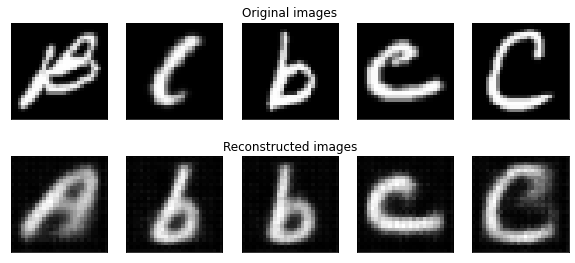

	 partial train loss (single batch): 12128.692383
	 partial train loss (single batch): 12024.058594
	 partial train loss (single batch): 11432.322266
	 partial train loss (single batch): 11517.271484
	 partial train loss (single batch): 11752.471680
	 partial train loss (single batch): 11785.848633
	 partial train loss (single batch): 12179.405273
	 partial train loss (single batch): 11554.800781
	 partial train loss (single batch): 11939.518555
	 partial train loss (single batch): 11934.596680
	 partial train loss (single batch): 11165.759766
	 partial train loss (single batch): 11839.075195
	 partial train loss (single batch): 11742.240234
	 partial train loss (single batch): 11874.917969
	 partial train loss (single batch): 11761.490234
	 partial train loss (single batch): 12175.114258
	 partial train loss (single batch): 11697.041992
	 partial train loss (single batch): 11984.139648
	 partial train loss (single batch): 11678.056641
	 partial train loss (single batch): 11687.217773


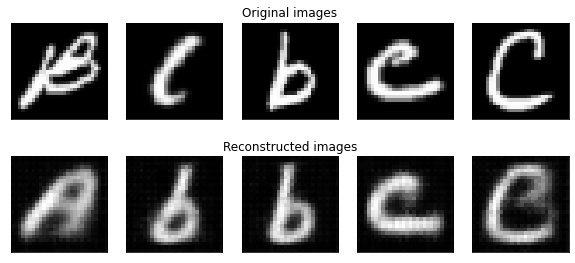

	 partial train loss (single batch): 12125.224609
	 partial train loss (single batch): 12062.580078
	 partial train loss (single batch): 11393.044922
	 partial train loss (single batch): 11400.232422
	 partial train loss (single batch): 11751.479492
	 partial train loss (single batch): 11814.503906
	 partial train loss (single batch): 12118.332031
	 partial train loss (single batch): 11639.729492
	 partial train loss (single batch): 11879.149414
	 partial train loss (single batch): 11821.506836
	 partial train loss (single batch): 11178.324219
	 partial train loss (single batch): 11818.208984
	 partial train loss (single batch): 11716.929688
	 partial train loss (single batch): 11812.191406
	 partial train loss (single batch): 11716.420898
	 partial train loss (single batch): 12081.505859
	 partial train loss (single batch): 11696.015625
	 partial train loss (single batch): 11992.997070
	 partial train loss (single batch): 11593.185547
	 partial train loss (single batch): 11630.597656


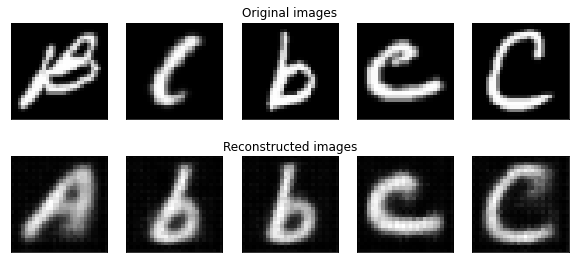

	 partial train loss (single batch): 12055.362305
	 partial train loss (single batch): 11986.177734
	 partial train loss (single batch): 11316.330078
	 partial train loss (single batch): 11416.924805
	 partial train loss (single batch): 11707.255859
	 partial train loss (single batch): 11789.804688
	 partial train loss (single batch): 12110.254883
	 partial train loss (single batch): 11545.591797
	 partial train loss (single batch): 11906.667969
	 partial train loss (single batch): 11766.314453
	 partial train loss (single batch): 11143.603516
	 partial train loss (single batch): 11713.706055
	 partial train loss (single batch): 11733.677734
	 partial train loss (single batch): 11769.145508
	 partial train loss (single batch): 11659.310547
	 partial train loss (single batch): 12062.480469
	 partial train loss (single batch): 11624.373047
	 partial train loss (single batch): 11958.344727
	 partial train loss (single batch): 11607.277344
	 partial train loss (single batch): 11585.993164


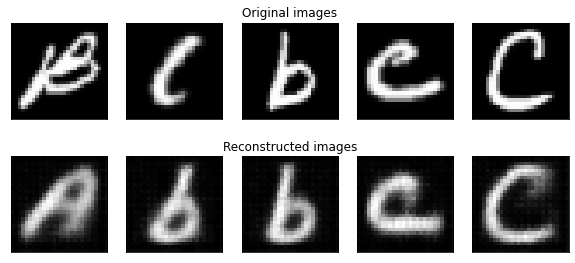

	 partial train loss (single batch): 11982.763672
	 partial train loss (single batch): 12015.530273
	 partial train loss (single batch): 11289.655273
	 partial train loss (single batch): 11293.888672
	 partial train loss (single batch): 11723.050781
	 partial train loss (single batch): 11736.135742
	 partial train loss (single batch): 12012.980469
	 partial train loss (single batch): 11534.990234
	 partial train loss (single batch): 11895.210938
	 partial train loss (single batch): 11772.045898
	 partial train loss (single batch): 11111.375000
	 partial train loss (single batch): 11790.728516
	 partial train loss (single batch): 11692.725586
	 partial train loss (single batch): 11833.076172
	 partial train loss (single batch): 11621.201172
	 partial train loss (single batch): 12132.416992
	 partial train loss (single batch): 11547.327148
	 partial train loss (single batch): 11891.101562
	 partial train loss (single batch): 11509.337891
	 partial train loss (single batch): 11615.261719


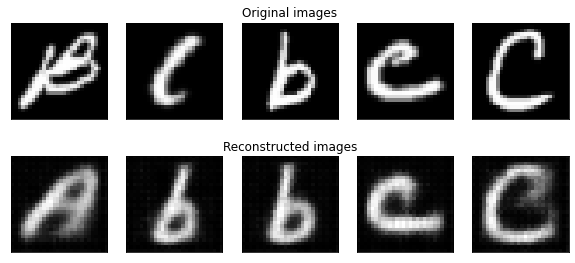

	 partial train loss (single batch): 11941.414062
	 partial train loss (single batch): 11951.427734
	 partial train loss (single batch): 11325.317383
	 partial train loss (single batch): 11372.416992
	 partial train loss (single batch): 11692.925781
	 partial train loss (single batch): 11662.135742
	 partial train loss (single batch): 12014.403320
	 partial train loss (single batch): 11518.453125
	 partial train loss (single batch): 11851.708984
	 partial train loss (single batch): 11747.483398
	 partial train loss (single batch): 11091.617188
	 partial train loss (single batch): 11661.681641
	 partial train loss (single batch): 11623.483398
	 partial train loss (single batch): 11730.292969
	 partial train loss (single batch): 11603.941406
	 partial train loss (single batch): 12043.865234
	 partial train loss (single batch): 11526.851562
	 partial train loss (single batch): 11914.659180
	 partial train loss (single batch): 11530.012695
	 partial train loss (single batch): 11577.414062


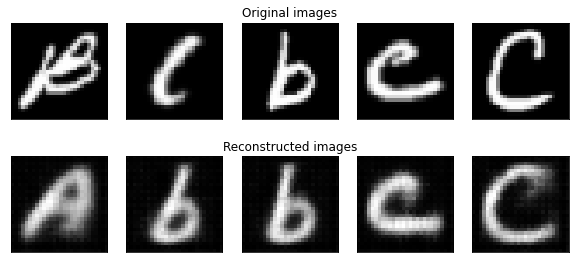

	 partial train loss (single batch): 11938.436523
	 partial train loss (single batch): 11998.043945
	 partial train loss (single batch): 11345.004883
	 partial train loss (single batch): 11308.532227
	 partial train loss (single batch): 11641.669922
	 partial train loss (single batch): 11655.653320
	 partial train loss (single batch): 12020.740234
	 partial train loss (single batch): 11503.996094
	 partial train loss (single batch): 11834.423828
	 partial train loss (single batch): 11847.076172
	 partial train loss (single batch): 11052.208984
	 partial train loss (single batch): 11695.126953
	 partial train loss (single batch): 11568.015625
	 partial train loss (single batch): 11770.973633
	 partial train loss (single batch): 11585.534180
	 partial train loss (single batch): 12012.662109
	 partial train loss (single batch): 11505.043945
	 partial train loss (single batch): 11963.695312
	 partial train loss (single batch): 11454.123047
	 partial train loss (single batch): 11554.980469


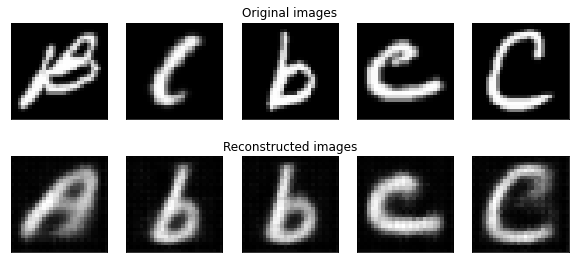

	 partial train loss (single batch): 11948.187500
	 partial train loss (single batch): 11929.596680
	 partial train loss (single batch): 11256.797852
	 partial train loss (single batch): 11223.204102
	 partial train loss (single batch): 11616.625000
	 partial train loss (single batch): 11689.411133
	 partial train loss (single batch): 12004.462891
	 partial train loss (single batch): 11490.977539
	 partial train loss (single batch): 11784.666016
	 partial train loss (single batch): 11801.990234
	 partial train loss (single batch): 11012.686523
	 partial train loss (single batch): 11741.676758
	 partial train loss (single batch): 11603.250000
	 partial train loss (single batch): 11738.070312
	 partial train loss (single batch): 11584.152344
	 partial train loss (single batch): 12055.586914
	 partial train loss (single batch): 11548.760742
	 partial train loss (single batch): 11861.477539
	 partial train loss (single batch): 11489.815430
	 partial train loss (single batch): 11541.004883


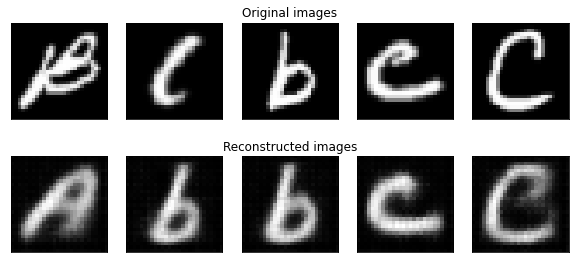

	 partial train loss (single batch): 11962.114258
	 partial train loss (single batch): 11907.486328
	 partial train loss (single batch): 11307.942383
	 partial train loss (single batch): 11241.776367
	 partial train loss (single batch): 11572.666992
	 partial train loss (single batch): 11684.877930
	 partial train loss (single batch): 11923.720703
	 partial train loss (single batch): 11467.741211
	 partial train loss (single batch): 11795.984375
	 partial train loss (single batch): 11732.242188
	 partial train loss (single batch): 10955.084961
	 partial train loss (single batch): 11649.309570
	 partial train loss (single batch): 11547.055664
	 partial train loss (single batch): 11706.714844
	 partial train loss (single batch): 11588.362305
	 partial train loss (single batch): 11991.554688
	 partial train loss (single batch): 11470.005859
	 partial train loss (single batch): 11843.570312
	 partial train loss (single batch): 11441.305664
	 partial train loss (single batch): 11501.640625


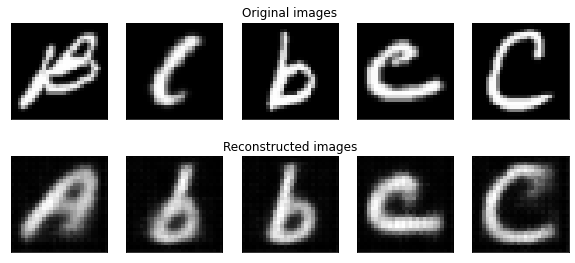

	 partial train loss (single batch): 11939.000977
	 partial train loss (single batch): 11826.860352
	 partial train loss (single batch): 11273.683594
	 partial train loss (single batch): 11241.050781
	 partial train loss (single batch): 11607.386719
	 partial train loss (single batch): 11631.231445
	 partial train loss (single batch): 12000.617188
	 partial train loss (single batch): 11475.435547
	 partial train loss (single batch): 11815.710938
	 partial train loss (single batch): 11723.433594
	 partial train loss (single batch): 11101.300781
	 partial train loss (single batch): 11710.398438
	 partial train loss (single batch): 11559.447266
	 partial train loss (single batch): 11647.744141
	 partial train loss (single batch): 11478.506836
	 partial train loss (single batch): 11942.521484
	 partial train loss (single batch): 11495.366211
	 partial train loss (single batch): 11822.053711
	 partial train loss (single batch): 11471.521484
	 partial train loss (single batch): 11447.115234


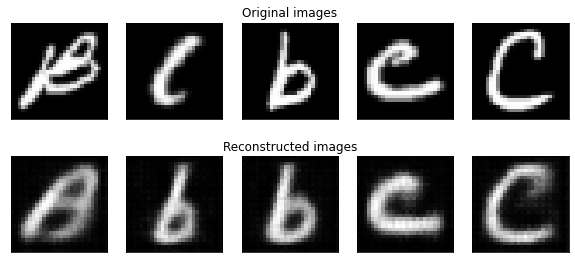

	 partial train loss (single batch): 11946.515625
	 partial train loss (single batch): 11914.328125
	 partial train loss (single batch): 11244.430664
	 partial train loss (single batch): 11348.636719
	 partial train loss (single batch): 11584.298828
	 partial train loss (single batch): 11692.257812
	 partial train loss (single batch): 11946.403320
	 partial train loss (single batch): 11426.132812
	 partial train loss (single batch): 11779.449219
	 partial train loss (single batch): 11743.057617
	 partial train loss (single batch): 11011.797852
	 partial train loss (single batch): 11670.171875
	 partial train loss (single batch): 11558.306641
	 partial train loss (single batch): 11758.233398
	 partial train loss (single batch): 11519.104492
	 partial train loss (single batch): 11956.493164
	 partial train loss (single batch): 11489.537109
	 partial train loss (single batch): 11802.107422
	 partial train loss (single batch): 11385.365234
	 partial train loss (single batch): 11448.919922


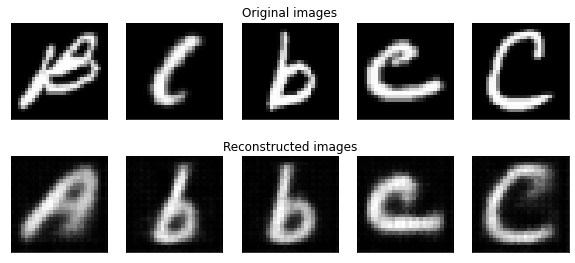

	 partial train loss (single batch): 11903.105469
	 partial train loss (single batch): 11925.625977
	 partial train loss (single batch): 11193.960938
	 partial train loss (single batch): 11243.993164
	 partial train loss (single batch): 11597.590820
	 partial train loss (single batch): 11618.488281
	 partial train loss (single batch): 11963.874023
	 partial train loss (single batch): 11506.011719
	 partial train loss (single batch): 11763.609375
	 partial train loss (single batch): 11703.031250
	 partial train loss (single batch): 11015.652344
	 partial train loss (single batch): 11610.294922
	 partial train loss (single batch): 11502.891602
	 partial train loss (single batch): 11677.427734
	 partial train loss (single batch): 11567.911133
	 partial train loss (single batch): 11925.035156
	 partial train loss (single batch): 11500.932617
	 partial train loss (single batch): 11814.448242
	 partial train loss (single batch): 11436.856445
	 partial train loss (single batch): 11411.682617


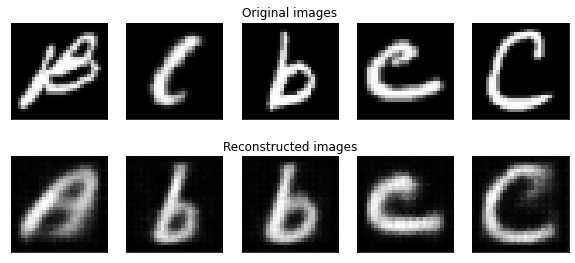

	 partial train loss (single batch): 11923.364258
	 partial train loss (single batch): 11898.538086
	 partial train loss (single batch): 11184.052734
	 partial train loss (single batch): 11217.002930
	 partial train loss (single batch): 11638.804688
	 partial train loss (single batch): 11564.380859
	 partial train loss (single batch): 11886.850586
	 partial train loss (single batch): 11388.984375
	 partial train loss (single batch): 11739.068359
	 partial train loss (single batch): 11742.490234
	 partial train loss (single batch): 10933.332031
	 partial train loss (single batch): 11560.315430
	 partial train loss (single batch): 11515.671875
	 partial train loss (single batch): 11642.912109
	 partial train loss (single batch): 11443.117188
	 partial train loss (single batch): 11907.615234
	 partial train loss (single batch): 11430.816406
	 partial train loss (single batch): 11778.635742
	 partial train loss (single batch): 11446.677734
	 partial train loss (single batch): 11450.388672


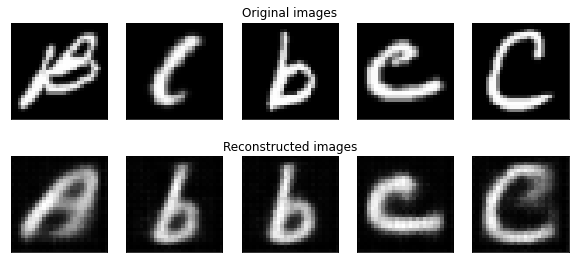

	 partial train loss (single batch): 11882.097656
	 partial train loss (single batch): 11807.555664
	 partial train loss (single batch): 11177.152344
	 partial train loss (single batch): 11191.852539
	 partial train loss (single batch): 11570.991211
	 partial train loss (single batch): 11554.430664
	 partial train loss (single batch): 11914.868164
	 partial train loss (single batch): 11388.428711
	 partial train loss (single batch): 11734.383789
	 partial train loss (single batch): 11721.382812
	 partial train loss (single batch): 10952.857422
	 partial train loss (single batch): 11507.572266
	 partial train loss (single batch): 11509.122070
	 partial train loss (single batch): 11656.878906
	 partial train loss (single batch): 11547.938477
	 partial train loss (single batch): 11848.231445
	 partial train loss (single batch): 11392.083984
	 partial train loss (single batch): 11735.345703
	 partial train loss (single batch): 11353.530273
	 partial train loss (single batch): 11548.690430


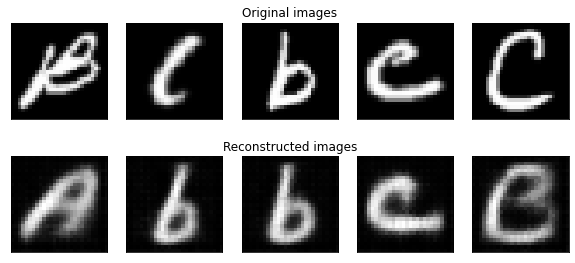

	 partial train loss (single batch): 11832.474609
	 partial train loss (single batch): 11939.701172
	 partial train loss (single batch): 11128.480469
	 partial train loss (single batch): 11219.843750
	 partial train loss (single batch): 11544.482422
	 partial train loss (single batch): 11592.048828
	 partial train loss (single batch): 11847.574219
	 partial train loss (single batch): 11361.356445
	 partial train loss (single batch): 11715.503906
	 partial train loss (single batch): 11702.541016
	 partial train loss (single batch): 10951.903320
	 partial train loss (single batch): 11525.173828
	 partial train loss (single batch): 11459.341797
	 partial train loss (single batch): 11638.870117
	 partial train loss (single batch): 11488.774414
	 partial train loss (single batch): 11851.945312
	 partial train loss (single batch): 11385.503906
	 partial train loss (single batch): 11797.597656
	 partial train loss (single batch): 11359.838867
	 partial train loss (single batch): 11451.618164


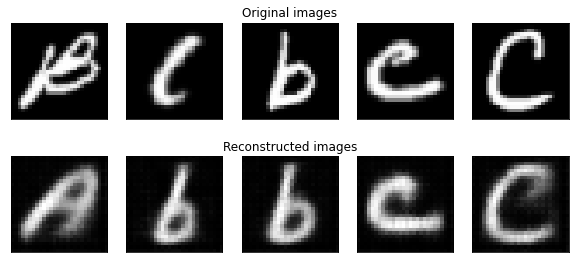

	 partial train loss (single batch): 11828.337891
	 partial train loss (single batch): 11831.832031
	 partial train loss (single batch): 11232.039062
	 partial train loss (single batch): 11244.285156
	 partial train loss (single batch): 11556.633789
	 partial train loss (single batch): 11641.985352
	 partial train loss (single batch): 11996.288086
	 partial train loss (single batch): 11380.954102
	 partial train loss (single batch): 11759.717773
	 partial train loss (single batch): 11715.011719
	 partial train loss (single batch): 10909.918945
	 partial train loss (single batch): 11499.755859
	 partial train loss (single batch): 11524.929688
	 partial train loss (single batch): 11681.080078
	 partial train loss (single batch): 11500.377930
	 partial train loss (single batch): 11929.129883
	 partial train loss (single batch): 11442.458984
	 partial train loss (single batch): 11690.198242
	 partial train loss (single batch): 11364.515625
	 partial train loss (single batch): 11439.963867


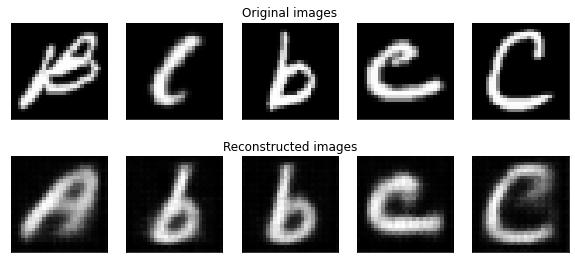

	 partial train loss (single batch): 11831.937500
	 partial train loss (single batch): 11758.112305
	 partial train loss (single batch): 11132.851562
	 partial train loss (single batch): 11151.304688
	 partial train loss (single batch): 11531.049805
	 partial train loss (single batch): 11572.227539
	 partial train loss (single batch): 11841.298828
	 partial train loss (single batch): 11396.660156
	 partial train loss (single batch): 11732.905273
	 partial train loss (single batch): 11685.626953
	 partial train loss (single batch): 10963.186523
	 partial train loss (single batch): 11567.631836
	 partial train loss (single batch): 11510.857422
	 partial train loss (single batch): 11573.102539
	 partial train loss (single batch): 11514.544922
	 partial train loss (single batch): 11943.997070
	 partial train loss (single batch): 11418.539062
	 partial train loss (single batch): 11739.804688
	 partial train loss (single batch): 11382.313477
	 partial train loss (single batch): 11384.514648


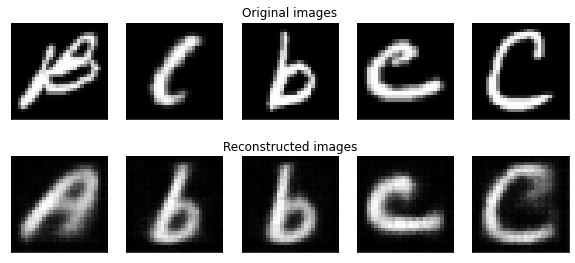

	 partial train loss (single batch): 11791.618164
	 partial train loss (single batch): 11859.408203
	 partial train loss (single batch): 11140.373047
	 partial train loss (single batch): 11187.896484
	 partial train loss (single batch): 11556.318359
	 partial train loss (single batch): 11540.327148
	 partial train loss (single batch): 11824.885742
	 partial train loss (single batch): 11398.908203
	 partial train loss (single batch): 11697.540039
	 partial train loss (single batch): 11621.580078
	 partial train loss (single batch): 10865.138672
	 partial train loss (single batch): 11461.523438
	 partial train loss (single batch): 11462.221680
	 partial train loss (single batch): 11579.518555
	 partial train loss (single batch): 11484.466797
	 partial train loss (single batch): 11876.527344
	 partial train loss (single batch): 11371.053711
	 partial train loss (single batch): 11763.833984
	 partial train loss (single batch): 11342.360352
	 partial train loss (single batch): 11432.192383


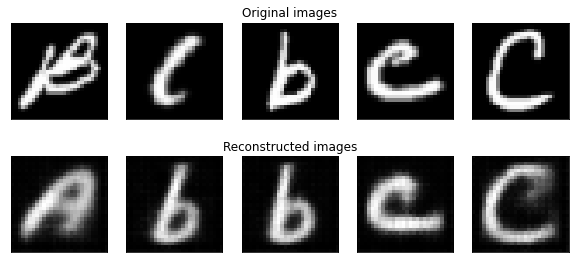

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):

   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

   plot_ae_outputs(vae.encoder,vae.decoder,n=5)

## 4.Generate samples

In [ ]:
def plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20,8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            #print("Z:", z)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')

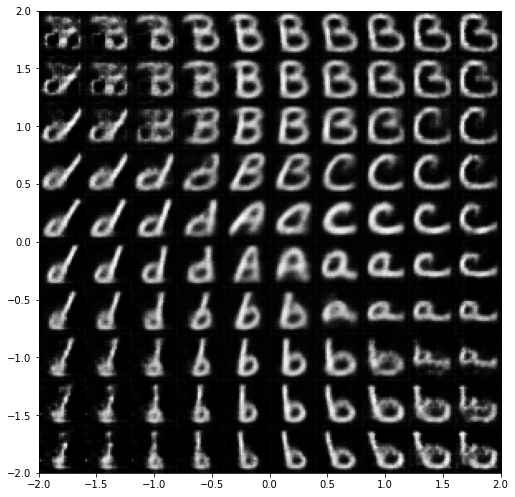

In [ ]:
plot_reconstructed(vae.decoder, r0=(-2, 2), r1=(-2, 2))

## 5.Visualize latent space

In [ ]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
        encoded_img  = vae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 2400/2400 [00:02<00:00, 1053.51it/s]


In [ ]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,label
0,-0.206251,0.226675,1
1,-0.573183,-0.744985,2
2,-0.192287,-0.962709,4
3,0.989019,-0.064571,2
4,0.797950,0.686885,2
...,...,...,...
2395,-0.483398,-1.307261,4
2396,-0.408247,-1.344134,4
2397,1.050887,0.500361,2
2398,-1.049101,0.079844,5


In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

In [ ]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()